In [37]:
# Get the progress bar going
!pip install tqdm

    100% |████████████████████████████████| 51kB 2.3MB/s ta 0:00:011
sagemaker 1.18.5 has requirement requests<2.21,>=2.20.0, but you'll have requests 2.21.0 which is incompatible.
docker-compose 1.23.2 has requirement requests!=2.11.0,!=2.12.2,!=2.18.0,<2.21,>=2.6.1, but you'll have requests 2.21.0 which is incompatible.
You are using pip version 10.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [44]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score

In [2]:
train_features = pd.read_csv('train_features.csv')
train_labels = pd.read_csv('train_labels.csv')['charged_off']
df = pd.concat([train_features, train_labels], axis=1)

In [6]:
train_features.shape, train_labels.shape, df.shape

((1309457, 103), (1309457,), (1309457, 104))

In [3]:
df = df.dropna(axis=1)

In [4]:
df = pd.get_dummies(df.drop(['id','charged_off'],axis=1), drop_first=True)

In [5]:
df.shape

(1309457, 1508)

In [7]:
X_train = MinMaxScaler().fit_transform(df)

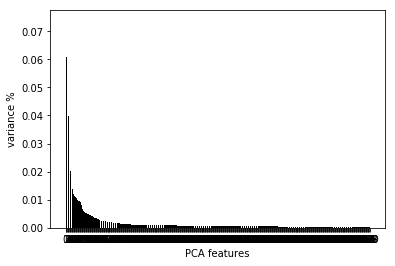

In [8]:
# Create a PCA instance: pca
pca = PCA(n_components=.95)
principalComponents = pca.fit_transform(X_train)
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

In [9]:
PCA_components = pd.DataFrame(principalComponents)

In [32]:
PCA_components.shape

(1309457, 460)

In [16]:
pd.concat([PCA_components, train_labels],axis=1).shape

(1309457, 461)

# Logistic Regression

In [42]:
X_train = PCA_components
y_train = train_labels

lr = LogisticRegression(solver='lbfgs', n_jobs=-1)
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [45]:
lr.score(X_train, y_train)

0.8017537040162449

In [46]:
cross_val_score(lr, X_train, y_train, cv=3, n_jobs=-1)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


array([0.80176958, 0.80161518, 0.80142502])

In [103]:
lr.predict_proba(X)[:,0]

array([0.97354614, 0.9692069 , 0.91067492, ..., 0.94321965, 0.5083664 ,
       0.95581797])

# Decision Tree Classifier

### Training data

In [47]:
# Create Decision Tree classifer object
dt = DecisionTreeClassifier(criterion="entropy", max_depth=3)

# Train Decision Tree Classifer
dt = dt.fit(X, y)

# CV score
dt.score(X,y)

0.8004508739118581

In [48]:
cross_val_score(dt, X_test, y, cv=3, n_jobs=-1)

array([0.80044996, 0.80045133, 0.80045133])

### Predict on out of sample data (test features)...

In [76]:
test = pd.read_csv("test_features.csv")
test.shape

(26724, 103)

In [94]:
X_test = pd.read_csv("test_features.csv")
X_test = X_test.dropna(axis=1)
X_test = pd.get_dummies(X_test.drop(['id'],axis=1), drop_first=True)
X_test.shape

(26724, 2055)

In [95]:
X_test = MinMaxScaler().fit_transform(X_test)

In [96]:
# Create a PCA instance: pca
pca = PCA(n_components=460)
principalComponents = pca.fit_transform(X_test)
# Save components to a DataFrame
X_test = pd.DataFrame(principalComponents)
X_test.shape

(26724, 460)

In [97]:
cross_val_score(dt, X_test, y.sample(26724), cv=4, n_jobs=-1)

array([0.79631847, 0.79808412, 0.79793444, 0.79715569])

# Kaggle Submission

In [86]:
sample_submission.head()

,id,charged_off
0,2264704,0.5
1,1896343,0.5
2,2077525,0.5
3,1846827,0.5
4,1210251,0.5


In [91]:
dt.predict_proba(X_test).shape

(26724, 2)

In [104]:
submission = sample_submission.copy()
submission['charged_off'] = dt.predict_proba(X_test)[:, 1]
submission.to_csv('submission-003.csv', index=False)

In [88]:
submission.head()

,id,charged_off
0,2264704,0.162431
1,1896343,0.221683
2,2077525,0.162431
3,1846827,0.301551
4,1210251,0.369441
